In [1]:
%pylab inline
import time
from collections import defaultdict
import json
import pandas as pd
import os
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout


import numpy as np
import requests
import json 

from datetime import datetime


from textblob import TextBlob
#import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Article creation date

## Awarded scientists

In [2]:
df_s=pd.read_csv("seed_revisions.csv",sep="\t")
df_s.info()
df_s=df_s[["article","text","timestamp"]]
df_s=df_s[~df_s.text.isnull()]
df_s.timestamp=pd.to_datetime(df_s.timestamp)
print len(df_s)


df_s["outlinks"]=df_s.text.apply(lambda x: map( lambda y:  y.split("]]")[0], x.split("[[")[1:])) 
df_s["outlinks"]=df_s.outlinks.apply( lambda x: [ i for i in x if (not ":" in i) or (": " in i) ])
df_s["outlinks"]=df_s.outlinks.apply( lambda x: [ i for i in x if (not "http:" in i) and (not "https:" in i) \
    and (not "Category:" in i) and (not "category:" in i) and (not "image:" in i) and (not "Image:" in i) \
    and (not "file:" in i)     and (not "File:" in i)     and (not "fi:" in i)    and (not "fr:" in i) \
    and (not "de:" in i)       and (not "ru:" in i)       and (not "zh:" in i)    and (not "vi:" in i) \
    and (not "categoría:" in i) and (not "it:" in i)     and (not "su:" in i)    and (not "Special:" in i)\
                                and (not "#Name|" in i)])

df_s["outlinks_len"]=df_s.outlinks.apply(len)
print df_s.info()

df_s=df_s[~df_s.outlinks_len.isnull()]
df_s=df_s[["article","outlinks_len","timestamp"]]

df_s.timestamp=df_s.timestamp.apply(lambda x: x.date() )
df_s.drop_duplicates(["timestamp","article"],keep="first",inplace=True)
print len(df_s)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63004 entries, 0 to 63003
Data columns (total 14 columns):
Unnamed: 0        63004 non-null object
_content_model    63004 non-null object
_parent_id        63004 non-null int64
_sha1             62984 non-null object
anon              63004 non-null object
article           63004 non-null object
comment           47173 non-null object
minor             63003 non-null object
revid             63002 non-null float64
rollbacktoken     0 non-null float64
text              62952 non-null object
timestamp         63002 non-null object
user              63002 non-null object
text_len          62952 non-null float64
dtypes: float64(3), int64(1), object(10)
memory usage: 6.7+ MB
62952
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62952 entries, 0 to 63003
Data columns (total 5 columns):
article         62952 non-null object
text            62952 non-null object
timestamp       62952 non-null datetime64[ns]
outlinks        62952 non-null obj

In [3]:
#for i in df_s.outlinks2.values:
#    for j in i:
#        #if (not "Wikipedia:" in j) and (not "Image:" in j) and (not "File:" in j) and (not "de:" in j) :"
#        if len(j)>150:
#            print j

In [15]:
df_s_w=pd.DataFrame(columns=["time_w","outlinks_len","article","week"])

g=df_s.groupby("article")
for article_name,series in g:
    print article_name
    created=series.timestamp.min()
    print created
    index=pd.date_range(start=created,end=datetime.today(),freq="W")
    #print index
    #series.timestamp=series.timestamp.apply(lambda x: x.date() )
    #series.drop_duplicates("timestamp",keep="first",inplace=True)
    
    df1=pd.DataFrame(index,columns=["time_w"])
    df1.time_w=df1.time_w.apply(lambda x: x.date() )
    df1["outlinks_len"]=df1.time_w.apply(lambda x: series[series.timestamp<=x].iloc[0].outlinks_len)
    df1["article"]=article_name
    df1["week"]=df1.index
    
    df_s_w=pd.concat([df_s_w,df1])

Ada_Yonath
2005-06-15
Adam_Riess
2006-07-13
Adrian_Bird
2009-02-05
Aharon_Razin
2009-10-07
Akira_Fujishima
2008-02-06
Akira_Suzuki_(chemist)
2010-03-21
Alain_Aspect
2004-12-21
Alan_Krueger
2006-08-23
Alberto_Alesina
2007-06-24
Allen_J._Bard
2008-07-07
Alvin_E._Roth
2008-06-27
Andre_Geim
2008-04-22
Andrew_Viterbi
2003-09-24
Angus_Deaton
2005-06-17
Anne_Osborn_Krueger
2004-03-05
Anthony_Pawson
2005-03-11
Anthony_R._Hunter
2007-03-31
Anton_Zeilinger
2004-08-21
Arieh_Warshel
2007-08-19
Armen_Alchian
2005-02-08
Arthur_B._McDonald
2007-11-02
Artur_Avila
2009-07-12
Aziz_Sancar
2006-06-06
B._Jayant_Baliga
2010-08-22
Barbara_Liskov
2005-02-15
Bernd_Giese
2009-10-10
Brian_Druker
2009-11-13
Brian_Kobilka
2008-10-16
Brian_Schmidt
2006-08-02
Bruce_Ames
2004-07-22
Bruce_Beutler
2007-11-27
C%C3%A9dric_Villani
2010-05-01
Carol_W._Greider
2006-11-27
Carolyn_R._Bertozzi
2006-11-27
Chad_Mirkin
2007-11-30
Charles_David_Allis
2006-06-02
Charles_F._Manski
2008-05-10
Charles_H._Bennett_(computer_scientist)
2

In [16]:
#group data by week number
df_s_w.info()
g=df_s_w.groupby("week")

s_w_st_dict=defaultdict()

for week_name,series in g:
    #print week_name
    #print series.outlinks_len.mean()
    #print series.sem().outlinks_len
    #print series.describe().outlinks_len
    s_w_st_dict[week_name]={"mean_w":series.outlinks_len.mean(),"std_1":series.outlinks_len.sem(),
                            "count":series.count().outlinks_len}
#create df
df_s_w_st=pd.DataFrame.from_dict(s_w_st_dict,orient="index")
df_s_w_st=df_s_w_st[df_s_w_st["count"]>10]
df_s_w_st.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 144435 entries, 0 to 119
Data columns (total 4 columns):
time_w          144435 non-null object
outlinks_len    144435 non-null object
article         144435 non-null object
week            144435 non-null object
dtypes: object(4)
memory usage: 5.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 762
Data columns (total 3 columns):
count     763 non-null int64
mean_w    763 non-null float64
std_1     763 non-null float64
dtypes: float64(2), int64(1)
memory usage: 23.8 KB


In [17]:
df_b2=pd.read_csv("baseline_revisions.csv",sep="\t")
df_b2.info()
df_b2=df_b2[["article","text","timestamp"]]
df_b2=df_b2[~df_b2.text.isnull()]
df_b2.timestamp=pd.to_datetime(df_b2.timestamp)
print len(df_b2)


df_b2["outlinks"]=df_b2.text.apply(lambda x: map( lambda y:  y.split("]]")[0], x.split("[[")[1:])) 
df_b2["outlinks"]=df_b2.outlinks.apply( lambda x: [ i for i in x if (not ":" in i) or (": " in i) ])
df_b2["outlinks"]=df_b2.outlinks.apply( lambda x: [ i for i in x if (not "http:" in i) and (not "https:" in i) \
    and (not "Category:" in i) and (not "category:" in i) and (not "image:" in i) and (not "Image:" in i) \
    and (not "file:" in i)     and (not "File:" in i)     and (not "fi:" in i)    and (not "fr:" in i) \
    and (not "de:" in i)       and (not "ru:" in i)       and (not "zh:" in i)    and (not "vi:" in i) \
    and (not "categoría:" in i) and (not "it:" in i)     and (not "su:" in i)    and (not "Special:" in i)\
                                and (not "#Name|" in i)])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24163 entries, 0 to 24162
Data columns (total 14 columns):
Unnamed: 0        24163 non-null int64
_content_model    24163 non-null object
_parent_id        24163 non-null int64
_sha1             24132 non-null object
anon              24163 non-null bool
article           24163 non-null object
comment           17697 non-null object
minor             24163 non-null bool
revid             24163 non-null int64
rollbacktoken     0 non-null float64
text              24126 non-null object
timestamp         24163 non-null object
user              24163 non-null object
text_len          24126 non-null float64
dtypes: bool(2), float64(2), int64(3), object(7)
memory usage: 2.3+ MB
24126


## Non-awarded scientists

In [9]:
df_b=pd.read_csv("baseline_revisions.csv",sep="\t")
df_b.info()
df_b=df_b[["article","text","timestamp"]]
df_b=df_b[~df_b.text.isnull()]
df_b.timestamp=pd.to_datetime(df_b.timestamp)
print len(df_b)


df_b["outlinks"]=df_b.text.apply(lambda x: map( lambda y:  y.split("]]")[0], x.split("[[")[1:])) 
df_b["outlinks"]=df_b.outlinks.apply( lambda x: [ i for i in x if (not ":" in i) or (": " in i) ])
df_b["outlinks"]=df_b.outlinks.apply( lambda x: [ i for i in x if (not "http:" in i) and (not "https:" in i) \
    and (not "Category:" in i) and (not "category:" in i) and (not "image:" in i) and (not "Image:" in i) \
    and (not "file:" in i)     and (not "File:" in i)     and (not "fi:" in i)    and (not "fr:" in i) \
    and (not "de:" in i)       and (not "ru:" in i)       and (not "zh:" in i)    and (not "vi:" in i) \
    and (not "categoría:" in i) and (not "it:" in i)     and (not "su:" in i)    and (not "Special:" in i)\
    and (not "Media:" in i)  and (not "#Name|" in i) and (not "pt:" in i) and (not "Catyegory:" in i)])
df_b["outlinks_len"]=df_b.outlinks.apply(len)
print df_b.info()

df_b=df_b[~df_b.outlinks_len.isnull()]
df_b=df_b[["article","outlinks_len","timestamp"]]

df_b.timestamp=df_b.timestamp.apply(lambda x: x.date() )
df_b.drop_duplicates(["timestamp","article"],keep="first",inplace=True)
print len(df_b)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24163 entries, 0 to 24162
Data columns (total 14 columns):
Unnamed: 0        24163 non-null int64
_content_model    24163 non-null object
_parent_id        24163 non-null int64
_sha1             24132 non-null object
anon              24163 non-null bool
article           24163 non-null object
comment           17697 non-null object
minor             24163 non-null bool
revid             24163 non-null int64
rollbacktoken     0 non-null float64
text              24126 non-null object
timestamp         24163 non-null object
user              24163 non-null object
text_len          24126 non-null float64
dtypes: bool(2), float64(2), int64(3), object(7)
memory usage: 2.3+ MB
24126
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24126 entries, 0 to 24162
Data columns (total 5 columns):
article         24126 non-null object
text            24126 non-null object
timestamp       24126 non-null datetime64[ns]
outlinks        24126 non-null ob

In [18]:
df_b_w=pd.DataFrame(columns=["time_w","outlinks_len","article","week"])

g=df_b.groupby("article")
for article_name,series in g:
    print article_name
    created=series.timestamp.min()
    print created
    index=pd.date_range(start=created,end=datetime.today(),freq="W")
    #print index
    #series.timestamp=series.timestamp.apply(lambda x: x.date() )
    #series.drop_duplicates("timestamp",keep="first",inplace=True)
    
    df1=pd.DataFrame(index,columns=["time_w"])
    df1.time_w=df1.time_w.apply(lambda x: x.date() )
    df1["outlinks_len"]=df1.time_w.apply(lambda x: series[series.timestamp<=x].iloc[0].outlinks_len)
    df1["article"]=article_name
    df1["week"]=df1.index
    

    df_b_w=pd.concat([df_b_w,df1])

%C4%90%C3%A0m_Thanh_S%C6%A1n
2013-02-20
%C5%BDeljko_Reiner
2013-02-17
Achim_M%C3%BCller
2005-12-22
Akiko_Iwasaki
2015-03-30
Alan_Aderem
2006-10-09
Alan_Ashworth
2010-01-28
Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si
2005-02-28
Albert_Meyers
2005-11-14
Alex_Bateman
2015-01-17
Alex_Zettl
2007-11-05
Alexander_Zamolodchikov
2008-10-21
Ali_Khademhosseini
2007-05-27
Allen_Steere
2007-05-28
Amir_Yacoby
2014-04-30
Andrei_Shleifer
2005-01-30
Andrew_Bernard
2007-05-18
Andrew_H._Van_de_Ven
2007-11-11
Annarosa_Leri
2015-05-07
Anne_O%27Garra
2008-07-20
Antonio_Lanzavecchia
2007-04-10
Ariel_Rubinstein
2005-03-26
Armin_Falk
2010-04-04
Arun_Majumdar
2009-09-20
Axel_D._Becke
2007-11-10
Axel_Ullrich
2006-06-03
Babak_Hassibi
2006-12-30
Barry_Everitt
2007-08-13
Bengt_R._Holmstr%C3%B6m
2016-10-13
Bernhard_Keimer
2014-02-01
Bernhard_Keller
2016-04-02
Beth_Levine_(physician)
2012-05-04
Birger_Wernerfelt
2007-12-10
Biswanath_Mukherjee
2015-02-05
Bradley_Efron
2006-10-02
Brigitta_Stockinger
2013-10-11
Bruce_D._Walke

In [19]:
#group data by week number
df_b_w.info()
g=df_b_w.groupby("week")

b_w_st_dict=defaultdict()

for week_name,series in g:
    #print week_name
    #print series.outlinks_len.mean()
    #print series.sem().outlinks_len
    #print series.describe().outlinks_len
    b_w_st_dict[week_name]={"mean_w":series.outlinks_len.mean(),"std_1":series.outlinks_len.sem(),
                            "count":series.count().outlinks_len}
#create df
df_b_w_st=pd.DataFrame.from_dict(b_w_st_dict,orient="index")
df_b_w_st=df_b_w_st[df_b_w_st["count"]>10]
df_b_w_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117995 entries, 0 to 570
Data columns (total 4 columns):
time_w          117995 non-null object
outlinks_len    117995 non-null object
article         117995 non-null object
week            117995 non-null object
dtypes: object(4)
memory usage: 4.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 678 entries, 0 to 677
Data columns (total 3 columns):
count     678 non-null int64
mean_w    678 non-null float64
std_1     678 non-null float64
dtypes: float64(2), int64(1)
memory usage: 21.2 KB


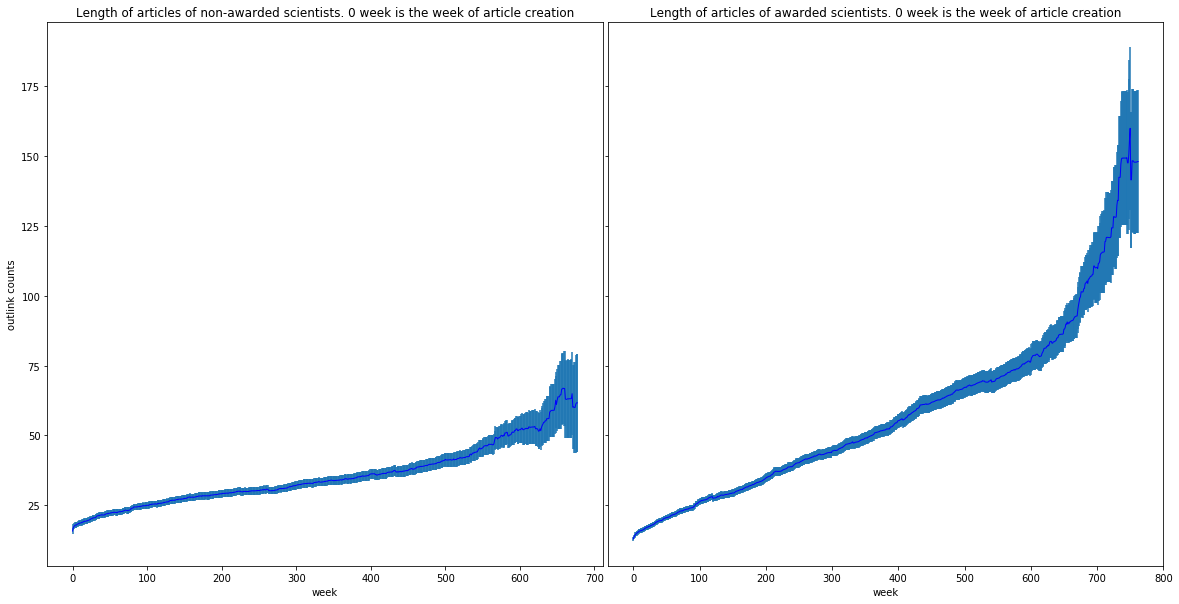

In [20]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True,figsize=[20,10])
ax0.errorbar(df_b_w_st.index.values, df_b_w_st.mean_w, df_b_w_st.std_1,linestyle='None')
ax0.plot(df_b_w_st.index.values, df_b_w_st.mean_w,"b",linewidth = 1)
#ax0.set_xlim(0,df_b_w_st.iloc[-1].name)
#ax0.set_ylim(10,5000)
ax0.set_xlabel("week")
ax0.set_ylabel("outlink counts")
ax0.set_title("Length of articles of non-awarded scientists. 0 week is the week of article creation")


ax1.errorbar(df_s_w_st.index.values, df_s_w_st.mean_w, df_s_w_st.std_1,linestyle='None')
ax1.plot(df_s_w_st.index.values, df_s_w_st.mean_w,"b",linewidth = 1)
#ax1.set_xlim(0,df_s_w_st.iloc[-1].name)
#plt.ylim(0,5000)
ax1.set_xlabel("week")
#plt.ylabel("word counts")
ax1.set_title('Length of articles of awarded scientists. 0 week is the week of article creation')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

# With date of award as 0 point

## awarded scientists

In [3]:
with open("seed_creation_date.json","r") as f:
    sci_aw_dict=json.load(f,encoding="utf-8")

In [4]:
df_sci_aw=pd.DataFrame.from_dict(sci_aw_dict,orient="index")
df_sci_aw.index=df_sci_aw.apply(lambda x: x.name.split("/")[-1],axis=1)
df_sci_aw.Award_date=pd.to_datetime(df_sci_aw.Award_date)
df_sci_aw.Award_date=df_sci_aw.Award_date.apply(lambda x: x.date() )


df_s_w_aw=pd.DataFrame(columns=["time_w","outlinks_len","article","week"])

g=df_s.groupby("article")
for article_name,series in g:
    print article_name
    created=series.timestamp.min()
    #print created
    #after award
    index=pd.date_range(start=df_sci_aw.loc[article_name].Award_date,end=datetime.today(),freq="W")
    #print index
    #before award
    index2=pd.date_range(end=df_sci_aw.loc[article_name].Award_date,start=created,freq="W")
    #print index2
    #series.timestamp=series.timestamp.apply(lambda x: x.date() )
    #series.drop_duplicates("timestamp",keep="first",inplace=True)
    
    df1_1=pd.DataFrame(index,columns=["time_w"])
    df1_1.time_w=df1_1.time_w.apply(lambda x: x.date() )
    
    if (created - df_sci_aw.loc[article_name].Award_date)>(created -created):
        df1_1=df1_1[df1_1.time_w>=created]
        df1_1["outlinks_len"]=df1_1.time_w.apply(lambda x: series[series.timestamp<=x].iloc[0].outlinks_len)
        #skip df1_2
        df1=df1_1[["time_w","outlinks_len"]]
        print "==> created after award"
    else:
        #print df1_1
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        #print df1_2
        df1_1["outlinks_len"]=df1_1.time_w.apply(lambda x: series[series.timestamp<=x].iloc[0].outlinks_len)
        #print df1_1
        df1_2["outlinks_len"]=df1_2.time_w.apply(lambda x: series[series.timestamp<=x].iloc[0].outlinks_len)
        df1=pd.concat([df1_1,df1_2])
    df1["article"]=article_name
    df1["week"]=df1.index
    
    df_s_w_aw=pd.concat([df_s_w_aw,df1])

Ada_Yonath
Adam_Riess
Adrian_Bird
Aharon_Razin
Akira_Fujishima
Akira_Suzuki_(chemist)
Alain_Aspect
Alan_Krueger
Alberto_Alesina
Allen_J._Bard
Alvin_E._Roth
Andre_Geim
Andrew_Viterbi
Angus_Deaton
Anne_Osborn_Krueger
Anthony_Pawson
Anthony_R._Hunter
Anton_Zeilinger
Arieh_Warshel
Armen_Alchian
Arthur_B._McDonald
Artur_Avila
Aziz_Sancar
B._Jayant_Baliga
Barbara_Liskov
Bernd_Giese
==> created after award
Brian_Druker
Brian_Kobilka
Brian_Schmidt
Bruce_Ames
Bruce_Beutler
C%C3%A9dric_Villani
Carol_W._Greider
Carolyn_R._Bertozzi
Chad_Mirkin
Charles_David_Allis
Charles_F._Manski
Charles_H._Bennett_(computer_scientist)
Charles_K._Kao
Charles_L._Bennett
Charles_L._Kane
Charles_Lee_(scientist)
Charles_M._Lieber
Charles_P._Thacker
Charles_Sawyers
Charles_T._Kresge
Ching_W._Tang
Christopher_A._Pissarides
Christopher_A._Sims
Dale_T._Mortensen
Dan_Shechtman
David_Card
David_Forbes_Hendry
David_J._Wineland
David_Julius
David_R._Smith
==> created after award
David_Spergel
Deborah_S._Jin
Dennis_Slamon
Did

In [5]:
#group data by week number
df_s_w_aw.info()
g=df_s_w_aw.groupby("week")

s_w_st_dict=defaultdict()

for week_name,series in g:
    #print week_name
    #print series.text_len.mean()
    #print series.sem().text_len
    #print series.describe().text_len
    s_w_st_dict[week_name]={"mean_w":series.outlinks_len.mean(),"std_1":series.outlinks_len.sem(),
                            "count":series.count().outlinks_len}
#create df
df_s_w_st_aw=pd.DataFrame.from_dict(s_w_st_dict,orient="index")
print len(df_s_w_st_aw)
df_s_w_st_aw=df_s_w_st_aw[df_s_w_st_aw["count"]>10]
print len(df_s_w_st_aw)
df_s_w_st_aw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144435 entries, 0 to 119
Data columns (total 4 columns):
time_w          144435 non-null object
outlinks_len    144435 non-null object
article         144435 non-null object
week            144435 non-null object
dtypes: object(4)
memory usage: 5.5+ MB
1123
1007
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007 entries, -522 to 484
Data columns (total 3 columns):
count     1007 non-null int64
mean_w    1007 non-null float64
std_1     1007 non-null float64
dtypes: float64(2), int64(1)
memory usage: 31.5 KB


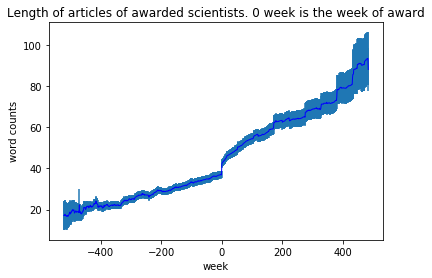

In [7]:
plt.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,linestyle='None')
plt.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,"b",linewidth = 1)
#plt.xlim(0,df_s_w_st.iloc[-1].name)
#plt.ylim(0,5000)
plt.xlabel("week")
plt.ylabel("word counts")
plt.title("Length of articles of awarded scientists. 0 week is the week of award");

In [8]:
print df_s_w_st_aw.loc[10]
print df_s_w_st_aw.loc[2]
print df_s_w_st_aw.loc[1]
print df_s_w_st_aw.loc[0]
print df_s_w_st_aw.loc[-1]
print df_s_w_st_aw.loc[-2]
print df_s_w_st_aw.loc[-10]

count     257.000000
mean_w     44.112840
std_1       1.987037
Name: 10, dtype: float64
count     257.000000
mean_w     42.824903
std_1       1.897014
Name: 2, dtype: float64
count     257.000000
mean_w     42.583658
std_1       1.883930
Name: 1, dtype: float64
count     257.000000
mean_w     42.252918
std_1       1.843108
Name: 0, dtype: float64
count     245.000000
mean_w     37.057143
std_1       1.781814
Name: -1, dtype: float64
count     243.000000
mean_w     36.798354
std_1       1.801585
Name: -2, dtype: float64
count     238.000000
mean_w     36.714286
std_1       1.869888
Name: -10, dtype: float64


## non-awarded scientists

In [10]:
def random_date(start, end, position=None):
    start, end = pd.Timestamp(start), pd.Timestamp(end)
    delta = (end - start).total_seconds()
    if position is None:
        offset = np.random.uniform(0., delta)
    else:
        offset = position * delta
    offset = pd.offsets.Second(offset)
    t = start + offset
    return t

In [11]:
print df_b.timestamp.min()
print df_b.timestamp.max()
print df_sci_aw.Award_date.min()
print df_sci_aw.Award_date.max()

2003-01-22
2018-01-01
2008-03-27
2015-10-12


In [12]:
#start=df_b.timestamp.min()
start=df_sci_aw.Award_date.min()
end=df_sci_aw.Award_date.max()
#end=df_b.timestamp.max()

In [13]:
df_s_w_naw=pd.DataFrame(columns=["time_w","outlinks_len","article","week"])

g=df_b.groupby("article")
for article_name,series in g:
    print article_name
    created=series.timestamp.min()
    #print created
    #after award
    award_date=random_date(start, end)
    index=pd.date_range(start=award_date,end=datetime.today(),freq="W")
    #print index
    #before award
    index2=pd.date_range(end=award_date,start=created,freq="W")
    #print index2
    #series.timestamp=series.timestamp.apply(lambda x: x.date() )
    #series.drop_duplicates("timestamp",keep="first",inplace=True)
    
    df1_1=pd.DataFrame(index,columns=["time_w"])
    df1_1.time_w=df1_1.time_w.apply(lambda x: x.date() )
    
    if (created -award_date.date())>(created-created):
        df1_1=df1_1[df1_1.time_w>=created]
        df1_1["outlinks_len"]=df1_1.time_w.apply(lambda x: series[series.timestamp<=x].iloc[0].outlinks_len)
        #skip df1_2
        df1=df1_1[["time_w","outlinks_len"]]
        print "==> created after award"
    else:
        #print df1_1
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        #print df1_2
        df1_1["outlinks_len"]=df1_1.time_w.apply(lambda x: series[series.timestamp<=x].iloc[0].outlinks_len)
        #print df1_1
        df1_2["outlinks_len"]=df1_2.time_w.apply(lambda x: series[series.timestamp<=x].iloc[0].outlinks_len)
        df1=pd.concat([df1_1,df1_2])
    df1["article"]=article_name
    df1["week"]=df1.index
    
    df_s_w_naw=pd.concat([df_s_w_naw,df1])

%C4%90%C3%A0m_Thanh_S%C6%A1n
%C5%BDeljko_Reiner
Achim_M%C3%BCller
Akiko_Iwasaki
==> created after award
Alan_Aderem
Alan_Ashworth
Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si
Albert_Meyers
Alex_Bateman
==> created after award
Alex_Zettl
Alexander_Zamolodchikov
Ali_Khademhosseini
Allen_Steere
Amir_Yacoby
==> created after award
Andrei_Shleifer
Andrew_Bernard
Andrew_H._Van_de_Ven
Annarosa_Leri
==> created after award
Anne_O%27Garra
Antonio_Lanzavecchia
Ariel_Rubinstein
Armin_Falk
==> created after award
Arun_Majumdar
Axel_D._Becke
Axel_Ullrich
Babak_Hassibi
Barry_Everitt
Bengt_R._Holmstr%C3%B6m
==> created after award
Bernhard_Keimer
==> created after award
Bernhard_Keller
==> created after award
Beth_Levine_(physician)
Birger_Wernerfelt
Biswanath_Mukherjee
==> created after award
Bradley_Efron
Brigitta_Stockinger
==> created after award
Bruce_D._Walker
==> created after award
C._N._R._Rao
Campbell_Harvey
==> created after award
Carlo_La_Vecchia
Cees_Dekker
Charles_M._Lieber
Chen_Guanrong
Chih-

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118009 entries, 0 to -1
Data columns (total 4 columns):
time_w          118009 non-null object
outlinks_len    118009 non-null object
article         118009 non-null object
week            118009 non-null object
dtypes: object(4)
memory usage: 4.5+ MB
1025
957
<class 'pandas.core.frame.DataFrame'>
Int64Index: 957 entries, -462 to 494
Data columns (total 3 columns):
count     957 non-null int64
mean_w    957 non-null float64
std_1     957 non-null float64
dtypes: float64(2), int64(1)
memory usage: 29.9 KB


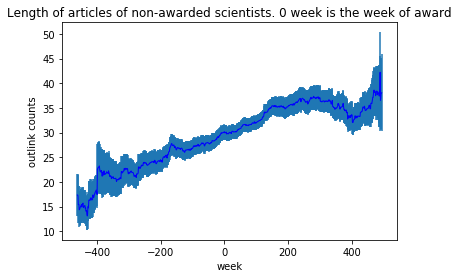

In [14]:
#group data by week number
df_s_w_naw.info()
g=df_s_w_naw.groupby("week")

s_w_st_dict=defaultdict()

for week_name,series in g:
    #print week_name
    #print series.text_len.mean()
    #print series.sem().text_len
    #print series.describe().text_len
    s_w_st_dict[week_name]={"mean_w":series.outlinks_len.mean(),"std_1":series.outlinks_len.sem(),
                            "count":series.count().outlinks_len}
#create df
df_s_w_st_naw=pd.DataFrame.from_dict(s_w_st_dict,orient="index")
print len(df_s_w_st_naw)
df_s_w_st_naw=df_s_w_st_naw[df_s_w_st_naw["count"]>10]
print len(df_s_w_st_naw)
df_s_w_st_naw.info()


plt.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,linestyle='None')
plt.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,"b",linewidth = 1)
#plt.xlim(0,df_s_w_st_naw.iloc[-1].name)
#plt.ylim(0,5000)
plt.xlabel("week")
plt.ylabel("outlink counts")
plt.title("Length of articles of non-awarded scientists. 0 week is the week of award");

In [22]:
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import seaborn.apionly as sns

#import imp
#imp.reload(mpl); imp.reload(plt); imp.reload(sns)

<module 'seaborn.apionly' from 'C:\Anaconda2\lib\site-packages\seaborn\apionly.pyc'>

In [ ]:
%pylab inline

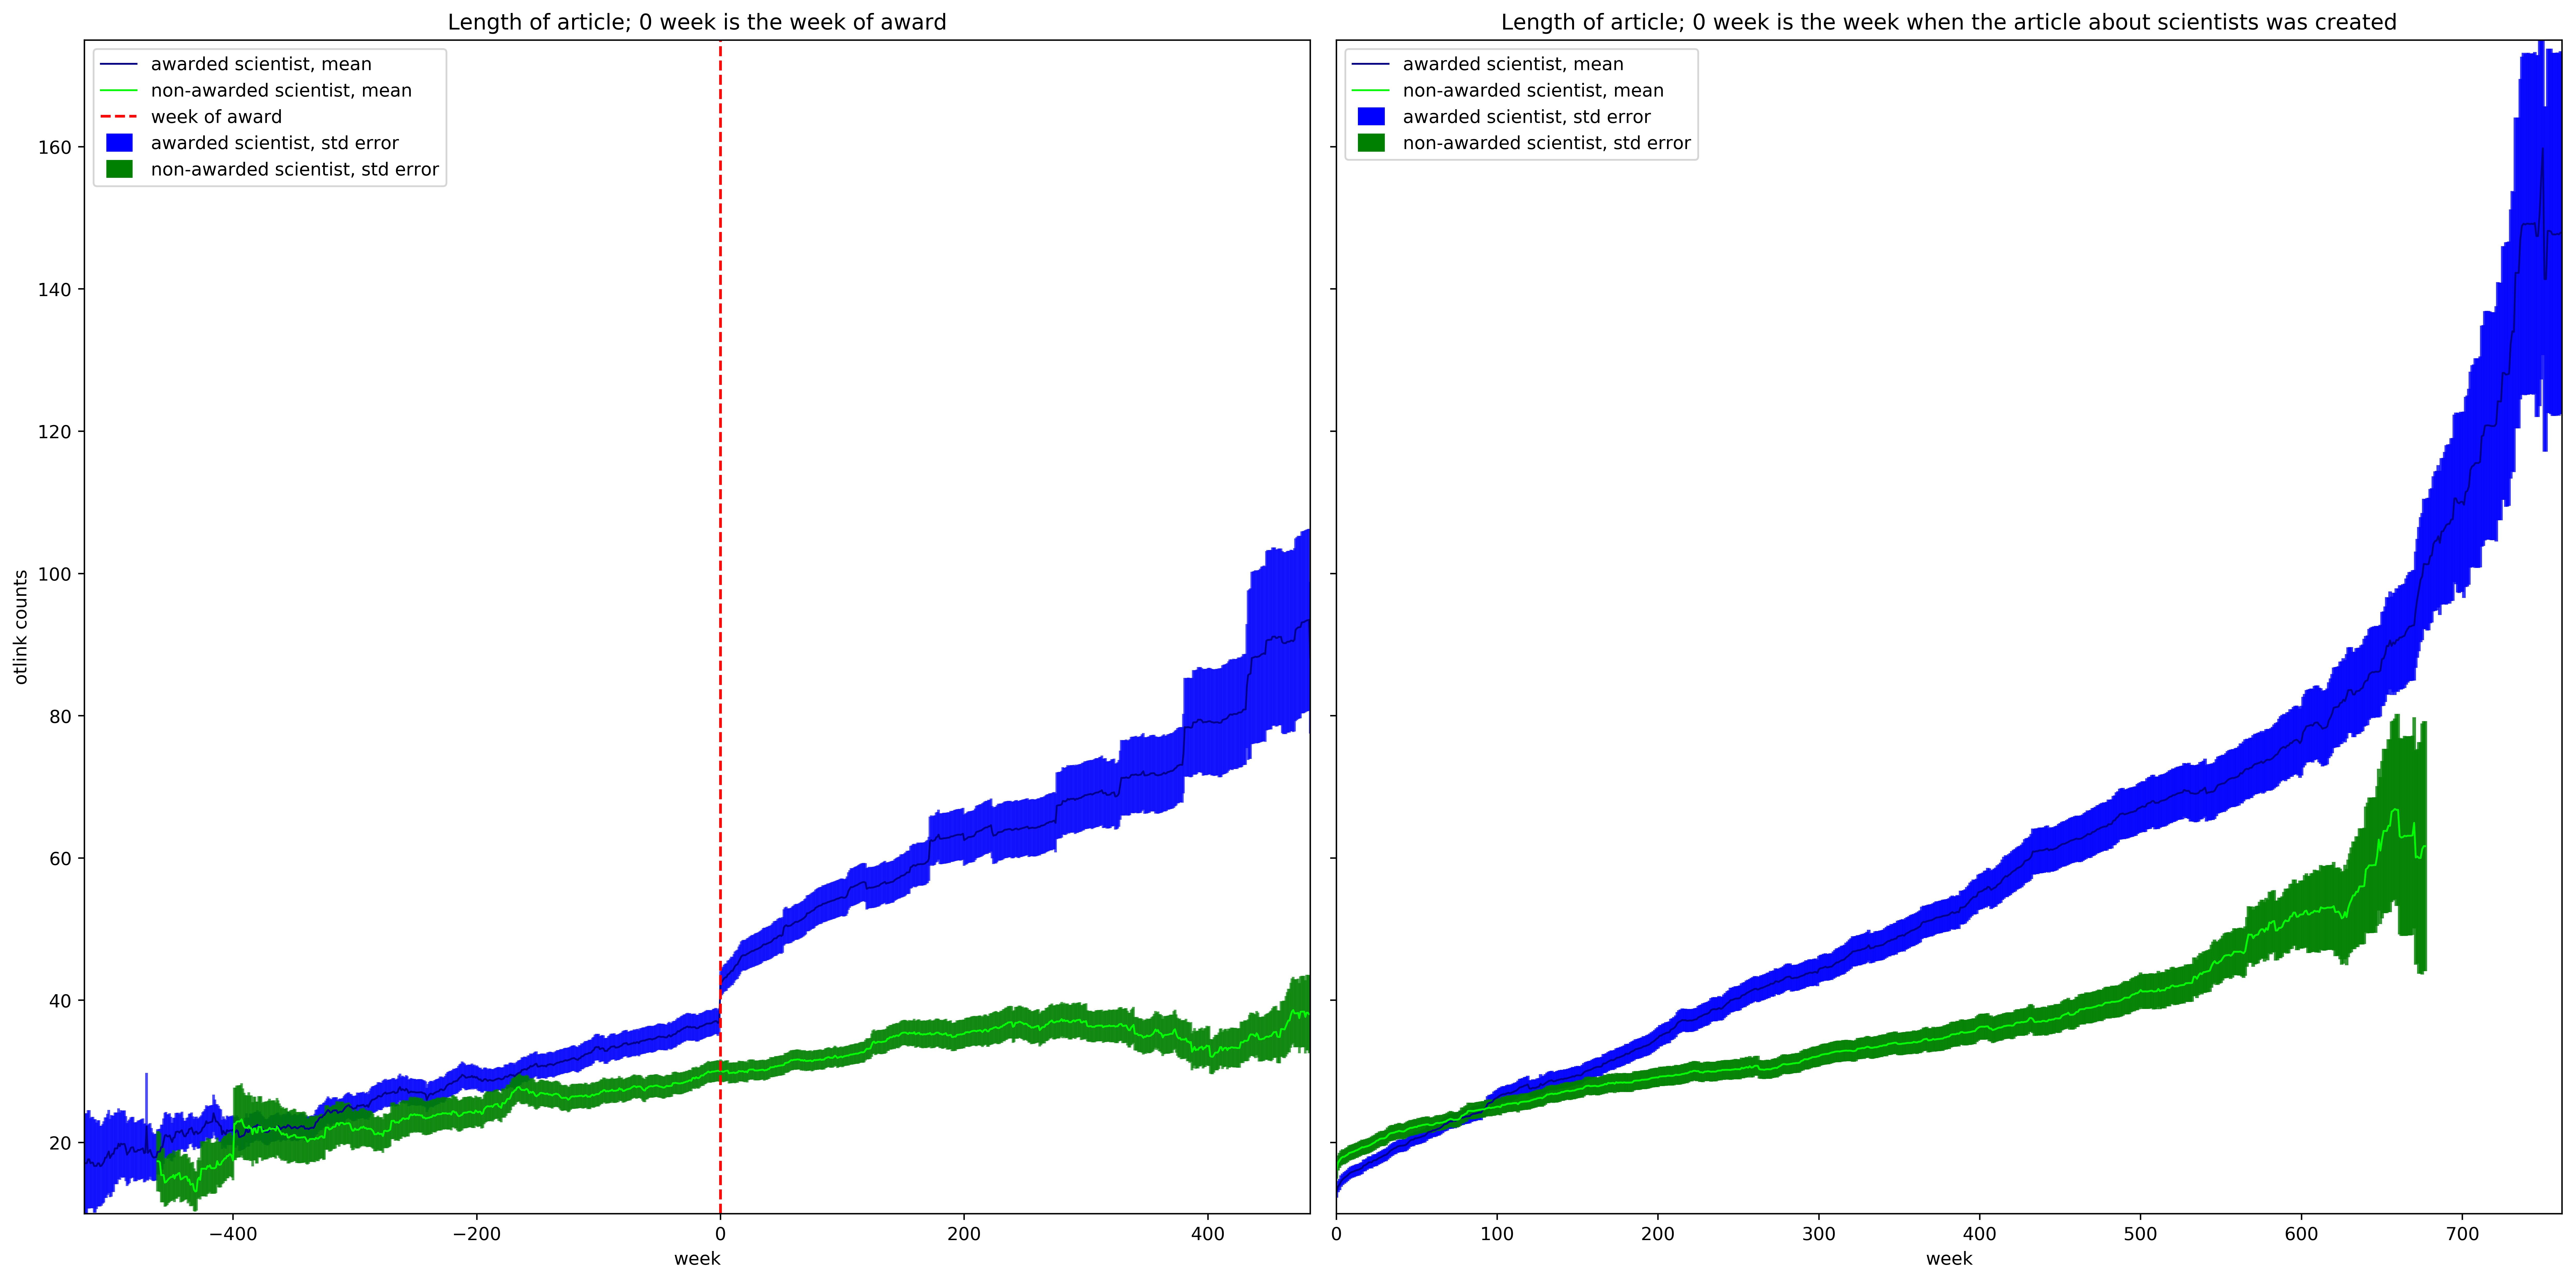

In [22]:
from matplotlib.container import ErrorbarContainer
from matplotlib.legend_handler import HandlerErrorbar

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True,figsize=[20,10],dpi=500)
ax0.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,c="b",alpha=0.7,#lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,"darkblue",linewidth = 1,label="awarded scientist, mean")
ax0.set_xlim(df_s_w_st_aw.iloc[0].name,df_s_w_st_aw.iloc[-1].name)
ax0.set_ylim(10,175)
ax0.set_xlabel("week")
ax0.set_ylabel("otlink counts")
ax0.set_title("Length of article; 0 week is the week of award")


ax0.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,c="green",alpha=0.7,#lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,"lime",linewidth = 1,label="non-awarded scientist, mean")
ax0.plot([0,0],[10,175],"r--",label="week of award")
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)


    
    
ax1.errorbar(df_s_w_st.index.values, df_s_w_st.mean_w, df_s_w_st.std_1,c="b",alpha=0.8,lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax1.plot(df_s_w_st.index.values, df_s_w_st.mean_w,"darkblue",linewidth = 1,label="awarded scientist, mean")
ax1.errorbar(df_b_w_st.index.values, df_b_w_st.mean_w, df_b_w_st.std_1,c="green",alpha=0.8,lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax1.plot(df_b_w_st.index.values, df_b_w_st.mean_w,"lime",linewidth = 1,label="non-awarded scientist, mean")
#ax1.legend(loc=2)
leg=ax1.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax1.set_xlim(df_s_w_st.iloc[0].name,df_s_w_st.iloc[-1].name)
ax1.set_xlabel("week")
#plt.ylabel("word counts")
ax1.set_title('Length of article; 0 week is the week when the article about scientists was created')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
plt.show()

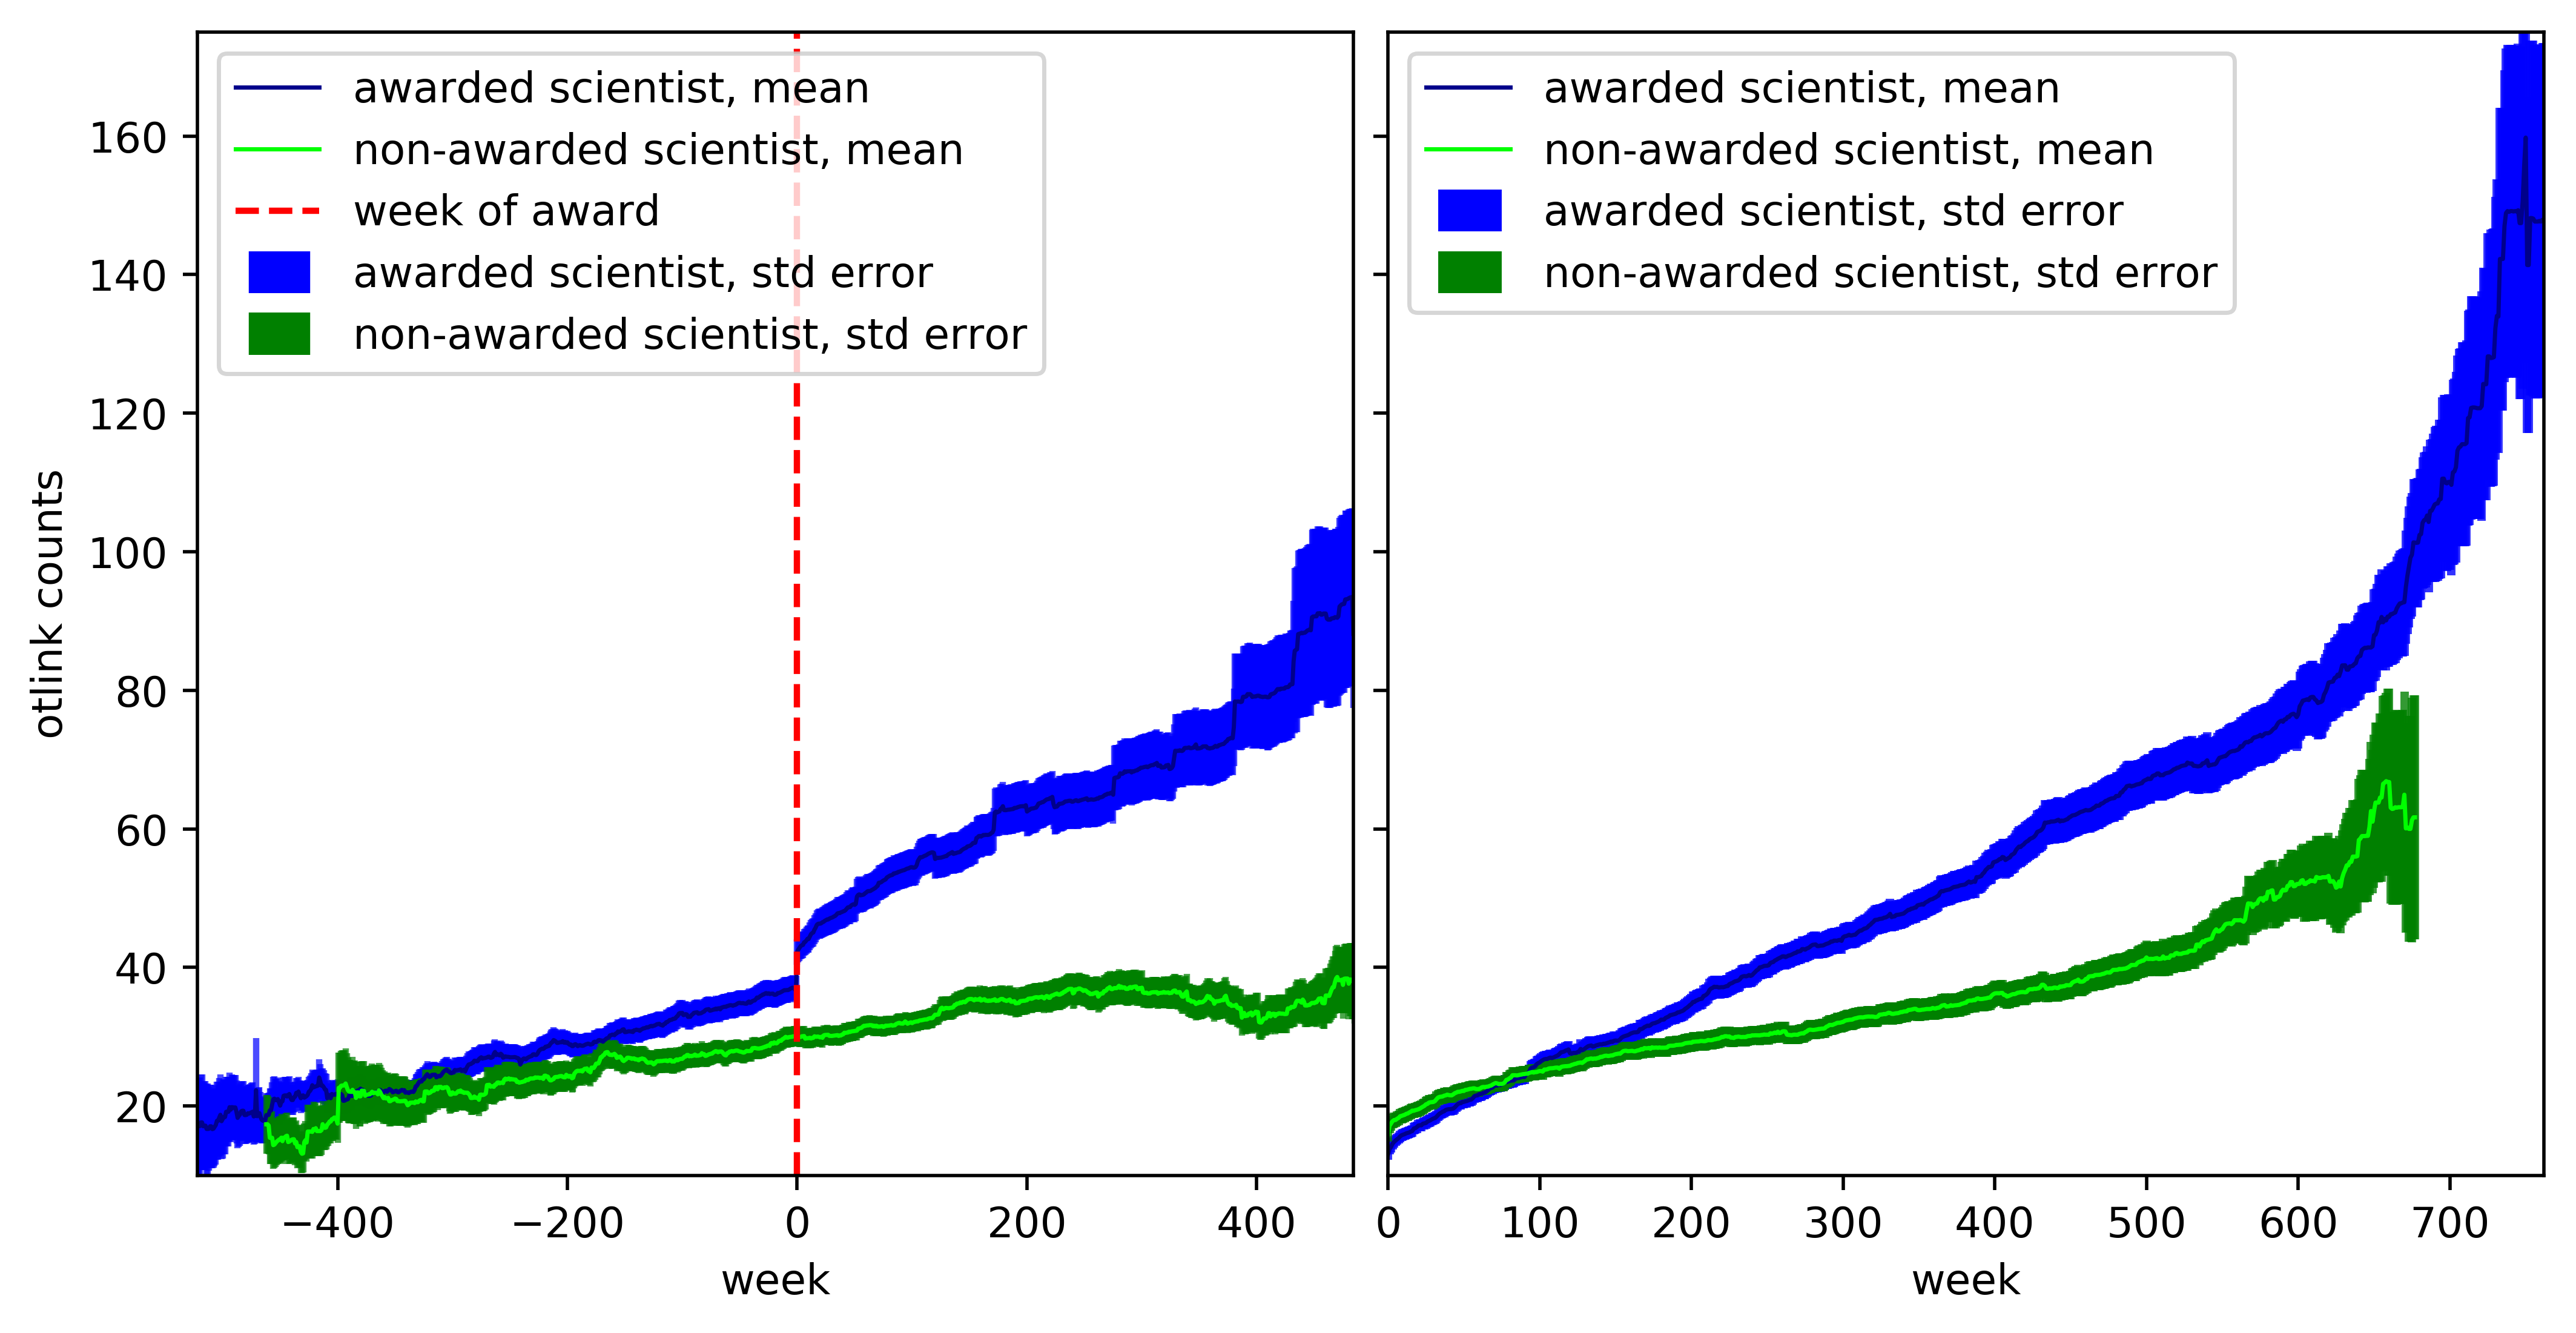

In [23]:
from matplotlib.container import ErrorbarContainer
from matplotlib.legend_handler import HandlerErrorbar

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True,figsize=[10,5],dpi=500)
ax0.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,c="b",alpha=0.7,#lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,"darkblue",linewidth = 1,label="awarded scientist, mean")
ax0.set_xlim(df_s_w_st_aw.iloc[0].name,df_s_w_st_aw.iloc[-1].name)
ax0.set_ylim(10,175)
ax0.set_xlabel("week")
ax0.set_ylabel("otlink counts")
#ax0.set_title("Length of article; 0 week is the week of award")


ax0.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,c="green",alpha=0.7,#lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,"lime",linewidth = 1,label="non-awarded scientist, mean")
ax0.plot([0,0],[10,175],"r--",label="week of award")
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)


    
    
ax1.errorbar(df_s_w_st.index.values, df_s_w_st.mean_w, df_s_w_st.std_1,c="b",alpha=0.8,lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax1.plot(df_s_w_st.index.values, df_s_w_st.mean_w,"darkblue",linewidth = 1,label="awarded scientist, mean")
ax1.errorbar(df_b_w_st.index.values, df_b_w_st.mean_w, df_b_w_st.std_1,c="green",alpha=0.8,lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax1.plot(df_b_w_st.index.values, df_b_w_st.mean_w,"lime",linewidth = 1,label="non-awarded scientist, mean")
#ax1.legend(loc=2)
leg=ax1.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax1.set_xlim(df_s_w_st.iloc[0].name,df_s_w_st.iloc[-1].name)
ax1.set_xlabel("week")
#plt.ylabel("word counts")
#ax1.set_title('Length of article; 0 week is the week when the article about scientists was created')

plt.subplots_adjust(wspace=0.03, hspace=0.03)
#plt.tight_layout()
plt.show()